In [1]:
# Install czmodel and dependencies (only needed once)
#! pip install --upgrade pip
#! pip install czmodel
#!pip install -q git+https://github.com/tensorflow/examples.git

In [2]:
# this can be used to switch on/off warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Simple TF2 + Keras model for segmentation (to detect cell nuclei)
This notebook the entire workflow of training an ANN with [TensorFlow 2](https://www.tensorflow.org/) using the keras API and exporting the trained model to the [czmodel format](https://pypi.org/project/czmodel/) to be ready for use within the [Intellesis](https://www.zeiss.com/microscopy/int/products/microscope-software/zen-intellesis-image-segmentation-by-deep-learning.html) infrastructure.

* The trained model is rather simple (for demo purposes) and trained on a small dataset.
* **Therefore, this notebook is meant to be understood as a guide for exporting trained models**
* **The notebook does not show how train a model correctly.**

In [3]:
# imports to train a simple TF2 + Keras model for segmentation

import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Optional: suppress TF warnings
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
print(tf.version.GIT_VERSION, tf.__version__)

v2.2.0-rc4-8-g2b96f3662b 2.2.0


## Training Pipeline
This section describes a **simple** training procedure that creates a trained Keras model.

* Therefore, it only represents the custom training procedure
* Such procedure will vary from case to case and will contain more sophisticated ways to generate an optimized Keras model

In [4]:
# Define the parameters for loading the training data

# place the original *.png images here
IMAGES_FOLDER = 'nucleus_data/images/'

# place the respective label *.png images here
# masks images have one channel (0=background and 1=nucleus)
MASKS_FOLDER = 'nucleus_data/label/'

# define the number of channels

# this means using a grayscale image with one channel only
CHANNELS = 1

# the model contains 2 classes, eg nuclei and background
NUM_CLASSES = 2

# tilesize for training which depends on the GPU memory size tec.
SZTR = 384

Remark: For details see [tf.one_hot](https://www.tensorflow.org/api_docs/python/tf/one_hot)

`tf.one_hot creates X channels from X labels: 1 => [0.0, 1.0], 0 => [1.0, 0.0]`

In [5]:
# This part contains the logic to read pairs of images and label masks for training !

# the the sample images
sample_images = sorted([os.path.join(IMAGES_FOLDER, f) for f in os.listdir(IMAGES_FOLDER)
                        if os.path.isfile(os.path.join(IMAGES_FOLDER, f))])

# get the maks
sample_masks = sorted([os.path.join(MASKS_FOLDER, f) for f in os.listdir(MASKS_FOLDER)
                       if os.path.isfile(os.path.join(MASKS_FOLDER, f))])

# load images as numpy arrays
images_loaded = np.asarray([tf.image.decode_image(tf.io.read_file(sample_path),
                                                  dtype=tf.dtypes.uint16,
                                                  channels=CHANNELS).numpy()
                            for sample_path in sample_images]).astype(np.float32)

# load labels as numpy arrays - set all pixels >0 to 1
masks_loaded = np.asarray([tf.one_hot(tf.cast(tf.cast(tf.image.decode_image(tf.io.read_file(sample_path),
                                                                            dtype=tf.dtypes.uint16,
                                                                            channels=1)[..., 0],
                                                      tf.dtypes.uint8) != 0,
                                              tf.dtypes.uint8),
                                      depth=NUM_CLASSES).numpy()
                           for sample_path in sample_masks])

In [6]:
def random_crop_and_pad_image_and_label(image, label, size):
    """Randomly crops image together with labels.

    Args:
      image: A Tensor with shape [D_1, ..., D_K, N]
      label: A Tensor with shape [D_1, ..., D_K, M]
      size: A Tensor with shape [K] indicating the crop size.
    Returns:
      A tuple of (cropped_image, cropped_label).
    """
    
    combined = tf.concat([image, label], axis=-1)
    image_shape = tf.shape(image)
    combined_pad = tf.image.pad_to_bounding_box(combined, 0, 0,
                                                tf.maximum(size[0], image_shape[0]),
                                                tf.maximum(size[1], image_shape[1]))
    
    last_label_dim = tf.shape(label)[-1]
    last_image_dim = tf.shape(image)[-1]
    
    combined_crop = tf.image.random_crop(combined_pad,
                                         size=tf.concat([size, [last_label_dim + last_image_dim]],
                                                        axis=0))
    
    return (combined_crop[:, :, :last_image_dim], combined_crop[:, :, last_image_dim:])


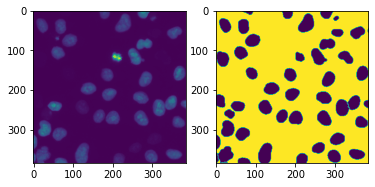

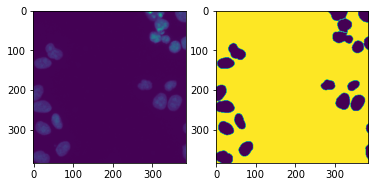

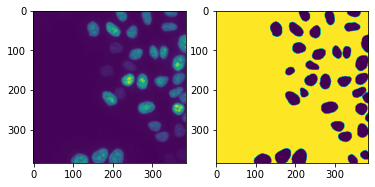

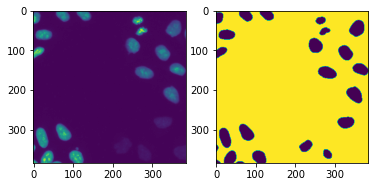

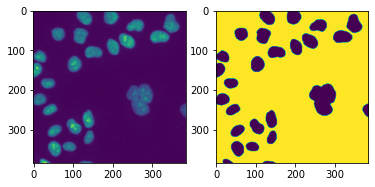

In [7]:
# check if the images fit to the labels - always a good idea ... :-)
for i in range(5):

    cropped_image, cropped_mask = random_crop_and_pad_image_and_label(image=images_loaded[i, ...],
                                                                      label=masks_loaded[i, ...],
                                                                      size=[SZTR, SZTR])
    # sho the images next to the labels
    fig, (ax1, ax2) = plt.subplots(1, 2)
    cropped_image = cropped_image.numpy()
    ax1.imshow(cropped_image[...,0])
    ax2.imshow(cropped_mask.numpy()[:,:,0])


In [ ]:
# cretae a tfdataset from the images and masks
tfdataset = tf.data.Dataset.from_tensor_slices((images_loaded, masks_loaded))

# apply the augmentation function to the tfdataset = just a random crop 
tfdataset = tfdataset.map(lambda image, label: random_crop_and_pad_image_and_label(image,
                                                                                   label,
                                                                                   size=[SZTR, SZTR])).batch(1)


### Define a simple model
This part defines a simple Keras model with two convolutional layers and softmax activation at the output node. It is also possible to add pre.processing layers to the model here.

In order to make the model robust to input scaling we standardize each image before training with the PerImageStandardization layer provided by the `czmodel` package.

In [ ]:
# Define simple Keras model with two convolutional layers and softmax activation at the output node

# those functions are provided by the PyPi package called czmodel (by ZEISS)
from czmodel.util.preprocessing import PerImageStandardization

model = tf.keras.models.Sequential([PerImageStandardization(input_shape=(None, None, CHANNELS)),
                                    tf.keras.layers.Conv2D(4, 3, activation='relu', padding='same'),
                                    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='same'),
                                    tf.keras.layers.Conv2D(8, 3, activation='relu', padding='same'),
                                    tf.keras.layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest'),
                                    tf.keras.layers.Conv2D(2, 1, activation='softmax', padding='same')])

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# show the model summary
model.summary()

### Fit the model to the loaded data
This part fits the model to the loaded data and evaluates it on the training data. In this test example we do not care about an actual evaluation of the model using validation and test data sets.

In [ ]:
# define number of training epochs
num_epochs = 100

# fit the model to the data
model.fit(tfdataset,
          batch_size=32,
          epochs=num_epochs)

# get the loss and acuary values
loss, accuracy = model.evaluate(tfdataset)

# show the final accuracy achieved
print("The model achieves {}% accuracy on the training data.".format(accuracy * 100))

In [ ]:
# create an iterator for the dataset
dataset_it = iter(tfdataset)

In [ ]:
# get an image and a mask from the dataset
img, mask = next(dataset_it)

#run the prediction and get the masks using argmax
pred = model.predict(img)[0]
pred = np.argmax(pred, axis=-1)

# scale the image and shwo the results - just re-execute the cell to display a different image
img_scaled = img.numpy()[0] / img.numpy().max()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(16)

# show images and set titles
ax1.imshow(img_scaled[...,0])
ax2.imshow(pred, cmap="gray", vmin=0, vmax=1)
ax3.imshow(mask[0,...,0])

ax1.set_title('Image')
ax2.set_title('Prediction')
ax3.set_title('Label Mask')

## Create a CZModel from the trained Keras model

In this section we export the trained model to the CZModel format using the czmodel library and some additional meta data all possible parameter choices are described in the [ANN model specification](https://pypi.org/project/czmodel/) that can be found on the PyPi packager for `czmodel`.

### Define Meta-Data

We first define the meta-data needed to run the model within the Intellesis infrastructure. The `czmodel` package offers a named tuple `ModelMetadata` that allows to either parse as JSON file as described or to directly specify the parameters as shown below.

### Create a Model Specification Object

The export functions provided by the `czmodel` package expect a `ModelSpec` tuple that features the Keras model to be exported and the corresponding model metadata.

Therefore, we wrap our model and the `model_metadata` instance into a `ModelSpec` object.

In [ ]:
# those functions are provided by the PyPi package called czmodel (by ZEISS)
from czmodel.util.preprocessing import add_preprocessing_layers
from czmodel.model_metadata import ModelMetadata, ModelSpec
from czmodel import convert_from_model_spec, convert_from_json_spec

# Define the model metadata
model_metadata = ModelMetadata.from_params(name='Simple_Nuclei_SegmentationModel', 
                                           color_handling='ConvertToMonochrome',
                                           pixel_type='Gray16',
                                           classes=["Background", "Nucleus"],
                                           border_size=20)


# Create a model specification object used for conversion
model_spec = ModelSpec(model=model, model_metadata=model_metadata)

### Perform model export into *.czmodel file format

The `czmodel` library offers two functions to perform the actual export. 

* `convert_from_json_spec` allows to provide a JSON file with all information to convert a model in SavedModel format on disk to a `.czmodel` file that can be loaded with ZEN.
* `convert_from_model_spec` expects a `ModelSpec` object, an output path and name and optionally target spatial dimensions for the expected input of the exported model. From this information it creates a `.czmodel` file containing the specified model.

```python
convert_from_model_spec(model_spec=model_spec, 
                        output_path=folder_to_store_czmodel, 
                        output_name=name_of_the_model, 
                        spatial_dims=spatial_dims)
```

In [ ]:
# Define dimensions - ZEN Intellesis requires fully defined spatial dimensions.
# This is the tile size used by the ZEN TilingStrategy to pass an image to the SegmentationService.

# Define target spatial dimensions of the model for inference.
spatial_dims = 1024, 1024


# package and save as CZMODEL - for inference the model will be exported as ONNX
convert_from_model_spec(model_spec=model_spec, 
                        output_path='./czmodel_output', 
                        output_name='simple_nuclei_segmodel', 
                        spatial_dims=spatial_dims)

# In the example above there will be a ""./czmodel_output/simple_nuclei_segmodel.czmodel" file saved on disk.

## Remarks
The generated .czmodel file can be directly loaded into ZEN Intellesis to perform segmentation tasks with the trained model.
If there is already a trained model in SavedModel format present on disk, it can also be converted by providing a meta-data JSON file as described in the [ANN Model Specification](https://pypi.org/project/czmodel/).

The following JSON document describes the same meta-data applied in the use case above:

```json
{
"BorderSize": 20,
"ColorHandling": "ConvertToMonochrome",
"PixelType": "Gray16",
"Classes": ["Background", "Nuclei"],
"ModelPath": "saved_tf2_model_output",
}
```

This information can be copied to a file e.g. in the current working directory `./model_spec.json` that also contains the trained model in SavedModel format e.g. generated by the following line:

In [ ]:
# save the trained TF2.SavedModel as a folder structure
# The folder + the JSON file can be also used to import the model in ZEN

model.save('./saved_tf2_model_output_dims_unset/') # save as TF.SavedModel without dims set

# add extra layer infont to define dimensions and save as TF2.SavedModel
add_preprocessing_layers(model, layers=None, spatial_dims=spatial_dims).save('./saved_tf2_model_output/')

**Example of a model XML description**

<img src="./mdpics/model_xml.png" >

To import the newly created model just use the **`Import`** function of the Intellesis Trainable Segmentation module in ZEN.

<img src="./mdpics/zen_import_model1.png" >

Select the **`simple_nuclei_segmodel.czmodel`** file and press the **`Open`** button.

<img src="./mdpics/zen_import_model2.png" >

Use the IP-function **`Segmentation`** to segment an image using the imported CZMODEL (containing the trained network).

<img src="./mdpics/zen_import_model_IPseg.png">

To use the trained model to analyse an image there are two main options

1. directly create an Image Analysis Setting based on the model (no class hierarchy, but very simple)
2. assign the trained model to s specific class inside a customized image analysis setting (shown below)

The crucial step (when not using option 1) is the Select the correct **`Class Segmentation Method`** inside the Image Analysis Wizard.

<img src="./mdpics/zen_import_model_IA1.png">

Use the **`Select Model`** function to assign the trained model and the actual **class** (from the trained model) of interest to assign the model / class to the respective object inside the image analysis setting.

<img src="./mdpics/zen_import_model_IA2.png" >

Now the trained model will be used to segment the image. The built-in ZEN Tiling Client automatically  to chunk the image and deal with complex dimensions, like Use the **`Scenes`** etc.

Additional Post-Processing options, incl. a Minimum Confidence Threshold can be applied to further refine the results.

<img src="./mdpics/zen_import_model_IA3.png" >

Finally, the model can be loaded into ZEN by using the **Import** function on the **JSON file**. 

If the model is supposed to be provided to other parties it is usually easier to exchange .czmodel files instead of SavedModel directories with corresponding JSON meta-data files.

The `czmodel` library also provides a `convert_from_json_spec` function that accepts the above mentioned JSON file and creates a CZModel:

In [ ]:
# This is an additional way how to create a CZMODEL from a saved TF2 model on disk + JSON file.
# The currently recommended way to to create the CZMODEL directly by using czmodel.convert_from_model_spec
# the path to the TF2.SavedModel folder is defined in the JSON shown above

convert_from_json_spec(model_spec_path='model_spec_dims_unset.json',
                       output_path='model_from_json',
                       output_name = 'simple_nuclei_segmodel_from_json',
                       spatial_dims=spatial_dims)

convert_from_json_spec(model_spec_path='model_spec.json',
                       output_path='model_from_json_dims_unset',
                       output_name = 'simple_nuclei_segmodel_from_json',
                       spatial_dims=None)

Use the commands below from a terminal to present the notebook as a slideshow.

`
jupyter nbconvert train_simple_TF2_segmentation_model.ipynb --to slides --post serve 
    --SlidesExporter.reveal_theme=serif 
    --SlidesExporter.reveal_scroll=True 
    --SlidesExporter.reveal_transition=none
`

Or install the [RISE Extension](https://rise.readthedocs.io/en/stable/) to display a a slideshow directly from within the notebook